In [1]:
# utils

import os
import cv2
import numpy as np
import pydicom as dicomio
import SimpleITK as sitk
from PIL import Image


def loadlist(path):
    list = os.listdir(path)
    list.sort()
    return list


def loadFile(filename):
    ds = sitk.ReadImage(filename)
    img_array = sitk.GetArrayFromImage(ds)
    if len(img_array.shape) == 3:
        frame_num, width, height = img_array.shape
        ch = 1
        return img_array, frame_num, width, height, ch
    elif len(img_array.shape) == 4:
        frame_num, width, height, ch = img_array.shape
        return img_array, frame_num, width, height, ch


def loadFileInformation(filename):
    information = {}
    ds = dicomio.read_file(filename, force=True)
    information["dicom_num"] = ds.SOPInstanceUID
    # information['PatientID'] = ds.PatientID
    # information['PatientName'] = ds.PatientName
    # information['PatientBirthDate'] = ds.PatientBirthDate
    # information['PatientSex'] = ds.PatientSex
    # information['StudyID'] = ds.StudyID
    # information['StudyDate'] = ds.StudyDate
    # information['StudyTime'] = ds.StudyTime
    # information['InstitutionName'] = ds.InstitutionName
    # information['Manufacturer'] = ds.Manufacturer
    # information['NumberOfFrames'] = ds.NumberOfFrames
    return information


def showImage(img_array):
    img_array = img_array
    img_bitmap = Image.fromarray(img_array)
    # img_bitmap.show()
    return img_bitmap


def MatrixToImage(data, ch):
    # data = (data+1024)*0.125
    # new_im = Image.fromarray(data.astype(np.uint8))
    # new_im.show()
    if ch == 3:
        img_rgb = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
    if ch == 1:
        data = (data + 1024) * 0.125
        img_rgb = data.astype(np.uint8)
    return img_rgb


def PETToImage(img_array, color_reversed=True):
    info = np.finfo(img_array.dtype)
    data = img_array.astype(np.float64) / np.max(img_array)
    if color_reversed is True:
        data = 255 - 255 * data
    elif color_reversed is False:
        data = 255 * data
    # data = (data + 1024) * 0.125
    img = data.astype(np.uint8)
    img = np.transpose(img, (1, 2, 0))
    # cv2.imshow('test', img)
    return img


def dfs_showdir(path, depth):
    if depth == 0:
        print("root:[" + path + "]")

    for item in os.listdir(path):
        if ".git" not in item:
            print("|      " * depth + "+--" + item)

            newitem = path + "/" + item
            if os.path.isdir(newitem):
                dfs_showdir(newitem, depth + 1)
    # print(path_list)


def isdir(x):
    return os.path.isdir(x) and x != ".svn"


def mkfloders(src, tar):
    paths = os.listdir(src)
    paths = map(lambda name: os.path.join(src, name), paths)
    paths = list(filter(isdir, paths))
    if len(paths) <= 0:
        return
    for i in paths:
        (filepath, filename) = os.path.split(i)
        targetpath = os.path.join(tar, filename)
        not os.path.isdir(targetpath) and os.mkdir(targetpath)
        mkfloders(i, targetpath)


def mkdir(path):

    isExists = os.path.exists(path)

    if not isExists:
        os.makedirs(path)
        print(path + " successfully be made!")
        return True
    else:
        print(path + " the folder already existed!")
        return False

In [30]:
# get_data_from_XML

import numpy as np
import os
from xml.etree import ElementTree


def get_category(category_file):
    class_list = []
    with open(category_file, "r") as f:
        for line in f.readlines():
            class_list.append(line.rstrip("\n"))

    return class_list


class XML_preprocessor(object):
    def __init__(self, data_path, num_classes, normalize=False):
        self.path_prefix = data_path
        self.num_classes = num_classes
        self.normalization = normalize
        self.data = {}
        self._preprocess_XML()

    def _preprocess_XML(self):
        filenames = os.listdir(self.path_prefix)
        for filename in filenames:
            tree = ElementTree.parse(os.path.join(self.path_prefix, filename))
            root = tree.getroot()
            bounding_boxes = []
            one_hot_classes = []
            size_tree = root.find("size")
            width = float(size_tree.find("width").text)
            height = float(size_tree.find("height").text)
            for object_tree in root.findall("object"):
                for bounding_box in object_tree.iter("bndbox"):
                    if self.normalization:
                        xmin = float(bounding_box.find("xmin").text) / width
                        ymin = float(bounding_box.find("ymin").text) / height
                        xmax = float(bounding_box.find("xmax").text) / width
                        ymax = float(bounding_box.find("ymax").text) / height
                    else:
                        xmin = float(bounding_box.find("xmin").text)
                        ymin = float(bounding_box.find("ymin").text)
                        xmax = float(bounding_box.find("xmax").text)
                        ymax = float(bounding_box.find("ymax").text)
                bounding_box = [xmin, ymin, xmax, ymax]
                bounding_boxes.append(bounding_box)
                class_name = object_tree.find("name").text
                one_hot_class = self._to_one_hot(class_name)
                one_hot_classes.append(one_hot_class)
            # image_name = root.find('filename').text
            image_name = filename
            bounding_boxes = np.asarray(bounding_boxes)
            one_hot_classes = np.asarray(one_hot_classes)
            image_data = np.hstack((bounding_boxes, one_hot_classes))
            self.data[image_name] = image_data

    def _to_one_hot(self, name):
        one_hot_vector = [0] * self.num_classes
        if name == "A":
            one_hot_vector[0] = 1
        elif name == "B":
            one_hot_vector[1] = 1
        elif name == "E":
            one_hot_vector[2] = 1
        elif name == "G":
            one_hot_vector[3] = 1
        else:
            print("unknown label: %s" % name)

        return one_hot_vector


## example on how to use it
# import pickle
# data = XML_preprocessor('VOC2007/Annotations/').data
# pickle.dump(data,open('VOC2007.p','wb'))

In [31]:
# get_gt

from xml.etree import ElementTree


def get_gt(filename, num_class, normalize=False):
    tree = ElementTree.parse(filename)
    root = tree.getroot()
    bounding_boxes = []
    one_hot_classes = []
    size_tree = root.find("size")
    width = float(size_tree.find("width").text)
    height = float(size_tree.find("height").text)
    for object_tree in root.findall("object"):
        for bounding_box in object_tree.iter("bndbox"):
            if normalize:
                xmin = float(bounding_box.find("xmin").text) / width
                ymin = float(bounding_box.find("ymin").text) / height
                xmax = float(bounding_box.find("xmax").text) / width
                ymax = float(bounding_box.find("ymax").text) / height
            else:
                xmin = float(bounding_box.find("xmin").text)
                ymin = float(bounding_box.find("ymin").text)
                xmax = float(bounding_box.find("xmax").text)
                ymax = float(bounding_box.find("ymax").text)
        bounding_box = [xmin, ymin, xmax, ymax]
        bounding_boxes.append(bounding_box)
        class_name = object_tree.find("name").text
        one_hot_class = _to_one_hot(class_name, num_class)
        one_hot_classes.append(one_hot_class)
    image_name = root.find("filename").text
    bounding_boxes = np.asarray(bounding_boxes)
    one_hot_classes = np.asarray(one_hot_classes)
    image_data = np.hstack((bounding_boxes, one_hot_classes))

    return image_name, image_data


def _to_one_hot(name, num_classes):
    one_hot_vector = [0] * num_classes
    if name == "A":
        one_hot_vector[0] = 1
    elif name == "B":
        one_hot_vector[1] = 1
    elif name == "E":
        one_hot_vector[2] = 1
    elif name == "G":
        one_hot_vector[3] = 1
    else:
        print("unknown label: %s" % name)

    return one_hot_vector

In [32]:
# getUID

# path = 'Data/02-06-2020/DICOM/Lung_Dx-G0011'
# path = '/home/wangshuo/Desktop/test_data/Lung-PET-CT-Dx/G0011'
# path = 'Data/02-06-2020/DICOM/Lung_Dx-G0011/04-29-2009-LUNGC-51228/2.000000-A phase 5mm Stnd SS50-53792/2-017.dcm'


def getUID_path(path):
    dict = {}
    file_list = os.listdir(path)

    for date in file_list:
        date_path = os.path.join(path, date)
        series_list = os.listdir(date_path)
        series_list.sort()

        for series in series_list:
            series_path = os.path.join(date_path, series)
            dicom_list = os.listdir(series_path)
            dicom_list.sort()

            for dicom in dicom_list:
                dicom_path = os.path.join(series_path, dicom)
                info = loadFileInformation(dicom_path)
                dict[info["dicom_num"]] = (dicom_path, dicom)

    #     for dicom in dicom_list:
    #         dicom_path = os.path.join(path, dicom)
    #         info = loadFileInformation(dicom_path)
    #         dict[info['dicom_num']] = (dicom_path, dicom)

    return dict


def getUID_file(path):
    info = loadFileInformation(path)
    UID = info["dicom_num"]
    return UID


# dict = getUID_file(path)
# print(dict)

In [33]:
# roi2rect

import cv2
import numpy as np


def showImage(img, title="image", t=0, esc=False):
    cv2.imshow(title, img)
    if esc:
        while cv2.waitKey(0) != 27:
            if cv2.getWindowProperty(title, cv2.WND_PROP_VISIBLE) <= 0:
                break
    else:
        cv2.waitKey(t)
    cv2.destroyWindow(title)


def class_colors(num_colors):
    class_colors = []
    for i in range(0, num_colors):
        hue = 255 * i / num_colors
        col = np.zeros((1, 1, 3)).astype("uint8")
        col[0][0][0] = hue
        col[0][0][1] = 128  # Saturation
        col[0][0][2] = 255  # Value
        cvcol = cv2.cvtColor(col, cv2.COLOR_HSV2BGR)
        col = (int(cvcol[0][0][0]), int(cvcol[0][0][1]), int(cvcol[0][0][2]))
        class_colors.append(col)

    return class_colors


def roi2rect(img_name, img_np, img_data, label_list):
    colors = class_colors(len(label_list))
    for rect in img_data:
        bounding_box = [rect[0], rect[1], rect[2], rect[3]]
        xmin = int(bounding_box[0])
        ymin = int(bounding_box[1])
        xmax = int(bounding_box[2])
        ymax = int(bounding_box[3])
        pmin = (xmin, ymin)
        pmax = (xmax, ymax)

        label_array = rect[4:]
        index = int(np.where(label_array == np.float(1))[0])
        label = label_list[index]

        # color = tuple(map(int, np.uint8(np.random.uniform(0, 255, 3))))
        color = colors[index]
        cv2.rectangle(img_np, pmin, pmax, color, 2)

        text_top = (xmin, ymin - 10)
        text_bot = (xmin + 80, ymin + 5)
        text_pos = (xmin + 5, ymin)
        cv2.rectangle(img_np, text_top, text_bot, colors[index], -1)
        cv2.putText(
            img_np,
            label,
            text_pos,
            cv2.FONT_HERSHEY_PLAIN,
            cv2.FONT_HERSHEY_PLAIN,
            1,
            1,
            2,
        )

    # cv2.imshow(img_name, img_np)
    # cv2.waitKey()
    # # return img_name, img_np
    # while cv2.waitKey(100) != 27:
    #     if cv2.getWindowProperty(img_name, cv2.WND_PROP_VISIBLE) <= 0:
    #         break
    # cv2.destroyWindow(img_name)

    showImage(img=img_np, title=img_name)

In [34]:
CLASS_LIST = ["A", "B", "D", "G"]
# path to the folder stored annotation files (.xml) or a path to a single annotation file
ANNOTATION_PATH = (
    "/home/mainlab1/TCCPauloLucas/Nodule_Classification/Lung-PET-CT-Dx-Test/A0001"
)
# choices=['CT', 'PET']
DICOM_MODE = "CT"
# path to the folder stored dicom files (.DCM)
DICOM_PATH = "/home/mainlab1/TCCPauloLucas/Nodule_Classification/Lung-PET-CT-Dx-Test/Lung_Dx-A0001"

num_classes = len(CLASS_LIST)
UID_dict = getUID_path(DICOM_PATH)

if os.path.isdir(ANNOTATION_PATH):
    annotations = XML_preprocessor(ANNOTATION_PATH, num_classes=num_classes).data
    for k, v in annotations.items():
        # dcm_name = k + '.dcm'
        dcm_path, dcm_name = UID_dict[k[:-4]]
        image_data = v

        if DICOM_MODE == "CT":
            matrix, frame_num, width, height, ch = loadFile(os.path.join(dcm_path))
            img_bitmap = MatrixToImage(matrix[0], ch)
        elif DICOM_MODE == "PET":
            img_array, frame_num, width, height, ch = loadFile(dcm_path)
            img_bitmap = PETToImage(img_array, color_reversed=True)

        roi2rect(
            img_name=dcm_name,
            img_np=img_bitmap,
            img_data=image_data,
            label_list=CLASS_LIST,
        )

elif os.path.isfile(ANNOTATION_PATH):
    xml_name = ANNOTATION_PATH.split("/")[-1]
    # dcm_name = xml_name[:-4] + '.dcm'
    dcm_path, dcm_name = UID_dict[xml_name[:-4]]
    _, image_data = get_gt(os.path.join(ANNOTATION_PATH), num_class=num_classes)

    if DICOM_MODE == "CT":
        matrix, frame_num, width, height, ch = loadFile(os.path.join(dcm_path))
        img_bitmap = MatrixToImage(matrix[0], ch)
    elif DICOM_MODE == "PET":
        img_array, frame_num, width, height, ch = loadFile(dcm_path)
        img_bitmap = PETToImage(img_array, color_reversed=True)

    roi2rect(
        img_name=dcm_name, img_np=img_bitmap, img_data=image_data, label_list=CLASS_LIST
    )

A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A


error: OpenCV(4.5.5) /io/opencv/modules/highgui/src/window.cpp:1268: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [17]:
# k = '1.3.6.1.4.1.14519.5.2.1.6655.2359.217649008723153656849717286154.xml'
# annotations['1.3.6.1.4.1.14519.5.2.1.6655.2359.217649008723153656849717286154.xml']
dcm_path, dcm_name = UID_dict[k[:-4]]

In [18]:
for rect in image_data:
    bounding_box = [rect[0], rect[1], rect[2], rect[3]]
    xmin = int(bounding_box[0])
    ymin = int(bounding_box[1])
    xmax = int(bounding_box[2])
    ymax = int(bounding_box[3])
    pmin = (xmin, ymin)
    pmax = (xmax, ymax)
bounding_box

[290.0, 315.0, 359.0, 393.0]

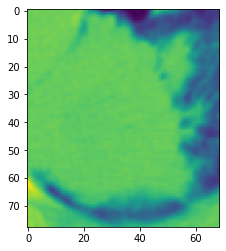

In [25]:
from pydicom import dcmread
import matplotlib.pyplot as plt

img = dcmread(dcm_path).pixel_array
plt.imshow(img[315:393, 290:359])